In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import PCA,SparsePCA,MiniBatchSparsePCA

import animate_helper as ah
reload(ah)

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


<module 'animate_helper' from '/mnt/home/szheng/projects/util_code/animate_helper.py'>

In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0
print(data_dir_full)
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913
load *SessionPulses.Events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/spk_beh_df.p saved!


In [105]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_d,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols_d['pyr'],speed_thresh=1,nbins=100,smth_in_bin=5,speed_key='v')
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'],speed_key='v')
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


<IPython.core.display.Javascript object>


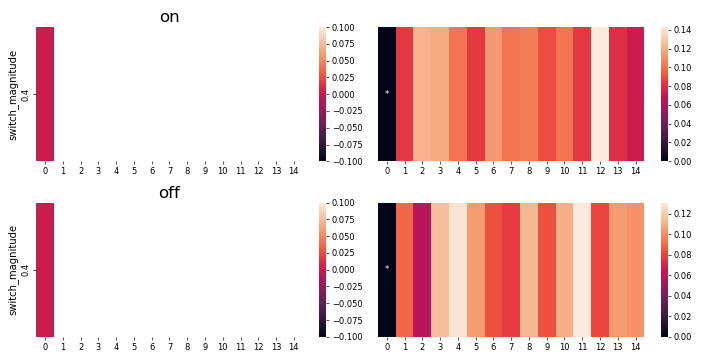

<IPython.core.display.Javascript object>


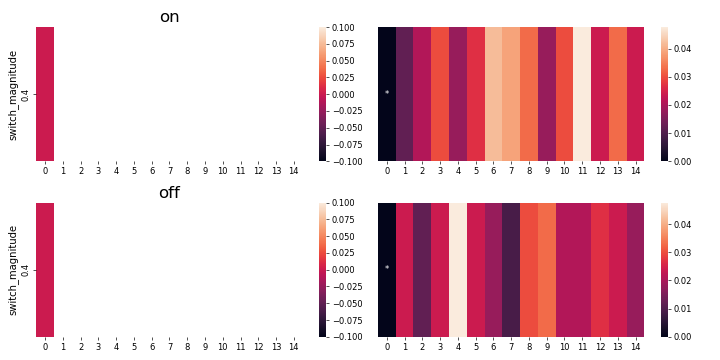

<IPython.core.display.Javascript object>


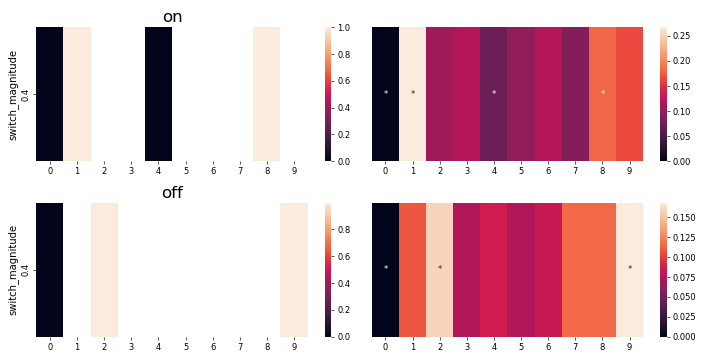

<IPython.core.display.Javascript object>


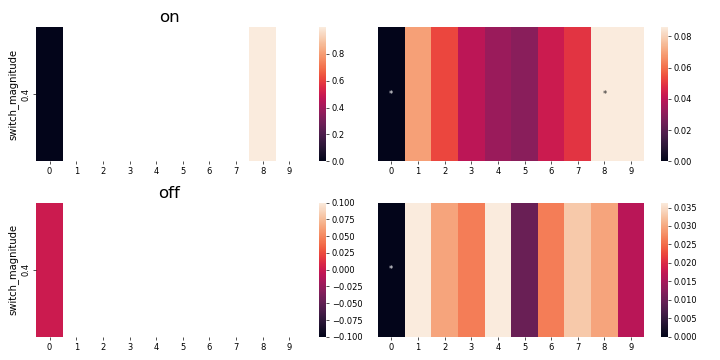

<IPython.core.display.Javascript object>


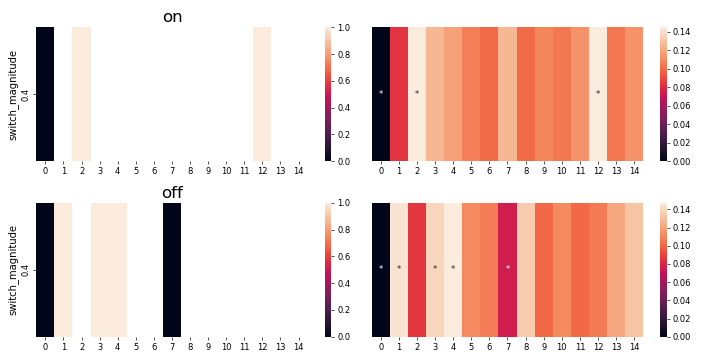

<IPython.core.display.Javascript object>


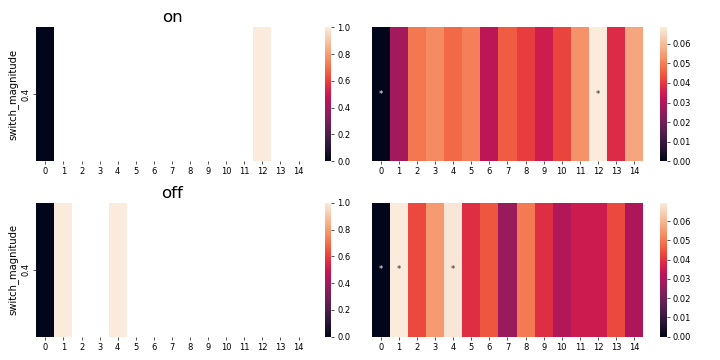

<IPython.core.display.Javascript object>


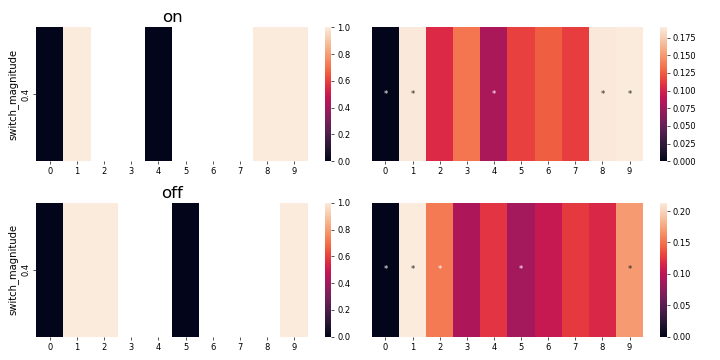

<IPython.core.display.Javascript object>


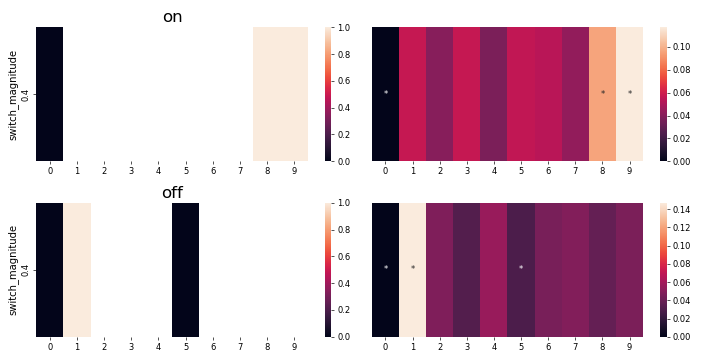

<IPython.core.display.Javascript object>


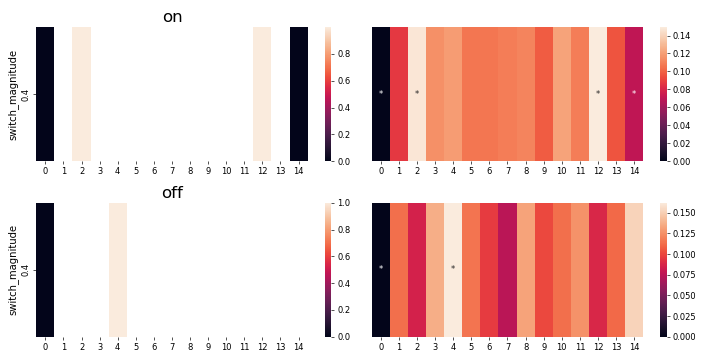

<IPython.core.display.Javascript object>


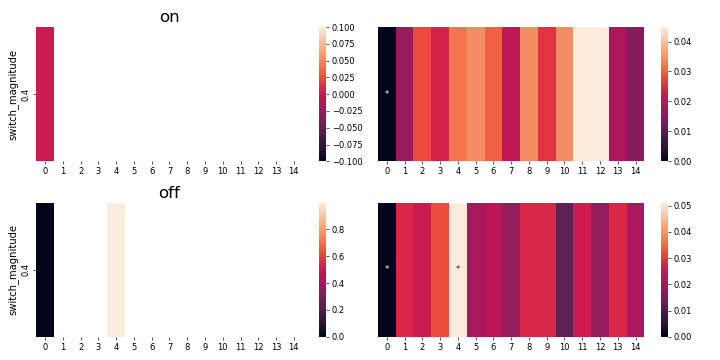

<IPython.core.display.Javascript object>


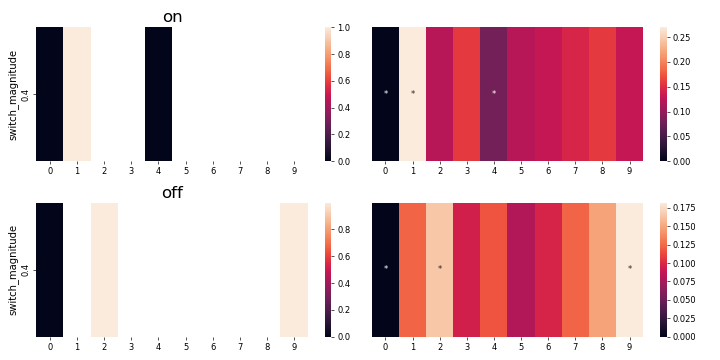

<IPython.core.display.Javascript object>


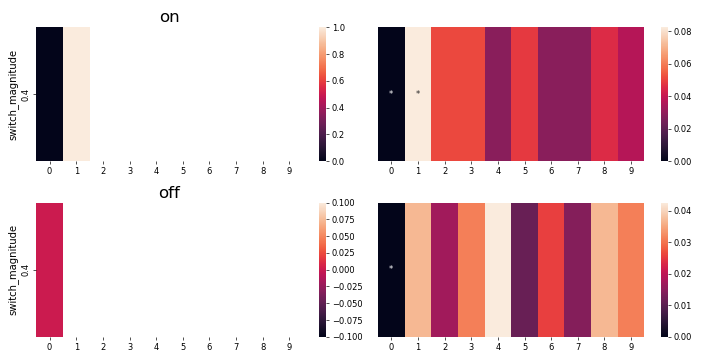

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [106]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

In [107]:
task_ind,tt_ind = 0,0
pf_param = pf_res['avg']['params'][task_ind,tt_ind]
changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)
fr_map_trial_df = fr_map_trial_df_d.loc[task_ind,tt_ind].dropna(axis=1)

no_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) ==0)].index
with_sw_fields = changes_df.loc[(changes_df.abs().sum(axis=1) !=0)].index

/tmp/ipykernel_261266/3810986821.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3,'switch_magnitude',0.4].dropna(axis=1)


In [109]:
# no speed thresh, get rate map
fr_map_d_run,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols_d['pyr'],speed_thresh=1,nbins=100,smth_in_bin=0,speed_key='speed')
fr_map_d_lowsp,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df.query('speed<1'),cell_cols_d['pyr'],speed_thresh=0,nbins=100,smth_in_bin=0,speed_key='speed')




In [7]:
import pca_analysis as pcaa
reload(pcaa)

import surrogate_data as sd

In [110]:
# preprocessing
fr_map_trial = fr_map_trial_d[task_ind,tt_ind]
reload(pcaa)
fr_map_trial_centered_normed_df,fr_map_trial_centered_normed = pcaa.preprocess_fr_map_trial(fr_map_trial,cell_cols)
X_l=pcaa.prep_X_l(fr_map_trial_centered_normed)

In [111]:
# low lam
reload(pcaa)
# w_l_allfac_fit, h_l_allfac_fit,l_all_allfac, l_recon_allfac, l_reg_allfac,w_l_allfac, h_l_allfac,r2_allfac, r2_pos_allfac  = \
#     pcaa.train_all_factor(X_l,n_fac=3,lam=1.,max_iters = 200, stop_thresh = 0.00001,
#                     fr_map_trial_centered_normed_df=fr_map_trial_centered_normed_df,w_l_allfac=None,h_l_allfac=None,
#                     pos_mask = None,return_init=True)


#high lam
reload(pcaa)
w_l_allfac_fit_highlam, h_l_allfac_fit_highlam,l_all_allfac, l_recon_allfac, l_reg_allfac,w_l_allfac, h_l_allfac,r2_allfac, r2_pos_allfac  = \
    pcaa.train_all_factor(X_l,n_fac=3,lam=20.,max_iters = 200, stop_thresh = 0.00001,
                    fr_map_trial_centered_normed_df=fr_map_trial_centered_normed_df,w_l_allfac=None,h_l_allfac=None,
                    pos_mask = None,return_init=True)


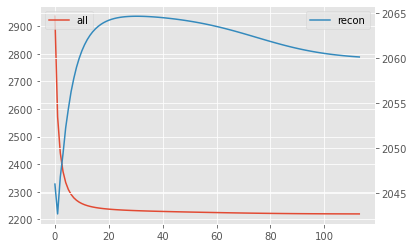

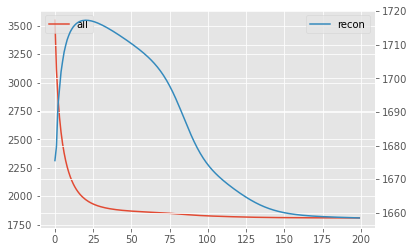

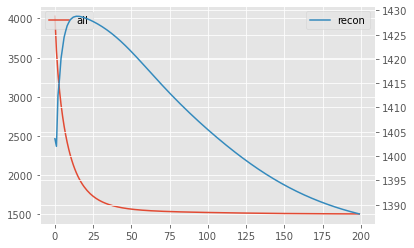

In [112]:
%matplotlib inline
for ee in range(len(l_all_allfac)):
    l_all_l = l_all_allfac[ee]
    l_recon_l = l_recon_allfac[ee]
    fig,ax=plt.subplots()
    ax.ticklabel_format(useOffset=False)
    ax.plot(l_all_l,label='all')
    ax2=ax.twinx()
    ax2.plot(l_recon_l,color='C1',label='recon')
    ax2.ticklabel_format(useOffset=False)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')


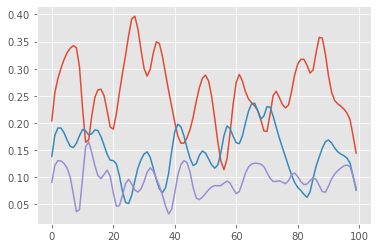

In [113]:
# plt.plot(r2_pos_allfac)
plt.plot(r2_pos_allfac.T)

In [114]:
reload(pcaa)
reload(ah)
h_l_allfac_fit_df = pcaa.post_process_loadings(h_l_allfac_fit_highlam)

trial_l = np.arange(h_l_allfac_fit_highlam.shape[-1])
color_l = ah.map_colors(trial_l,npos=None,cmap_name='vlag')

<IPython.core.display.Javascript object>


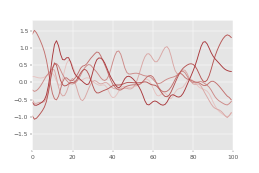

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_figures/vbpca/pc2_vs_pos_lam20.gif saved!


In [119]:
%matplotlib notebook
eig_ind = 2

save_kws=dict(
    root = data_dir_full,
    sub_dir = 'vbpca',
    name=f'pc{eig_ind}_vs_pos_lam20',
    fps=5
)


data = h_l_allfac_fit_highlam[:,eig_ind,:]
data = np.concatenate([np.arange(data.shape[0])[:,None],data],axis=1)

reload(ah)
fig,ax,ani=ah.animate_line_morph(data,legend_handles=None,color_l=color_l,max_length=5,fig=None,ax=None,ax_kws={'xlim':(0,100)},animate_kws={'interval':200},dosave=True,save_kws=save_kws)




<IPython.core.display.Javascript object>


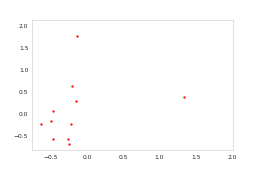

In [154]:
%matplotlib notebook
# two pcs simultaneously, for one position
p=10
data=h_l_allfac_fit_highlam[p,:2,:]
reload(ah)
fig,ax,ani=ah.animate_movement_in_maze(data,None,None,hist2d_kws={},ax_kws={},fig=None,ax=None,
                                    animate_kws={'interval':500},dosave=False,
                                    plot_background_maze=False
                                )

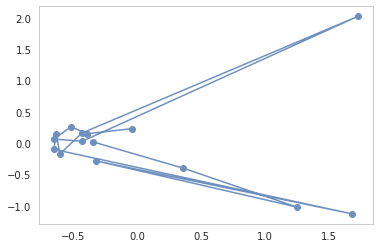

In [147]:
plt.plot(h_l_allfac_fit_highlam[0,0,:],h_l_allfac_fit_highlam[0,1,:],marker='o')

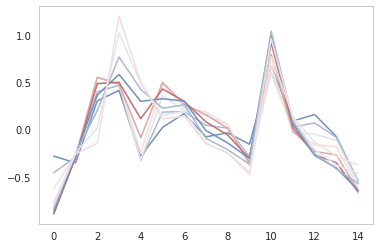

In [143]:
plt.plot(h_l_allfac_fit_highlam[60:70,2,:].T)

<IPython.core.display.Javascript object>


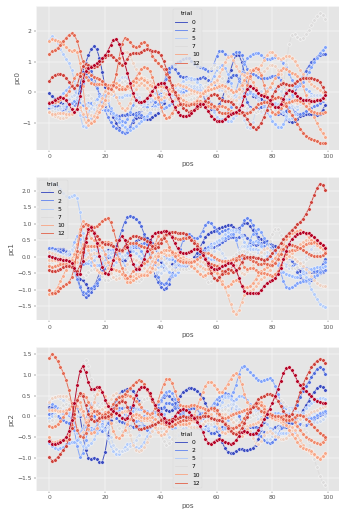

In [120]:
%matplotlib notebook
# toplot = h_l_allfac_fit_df.query('trial<=33')
toplot = h_l_allfac_fit_df
# toplot = h_one_trial_df_l.query('25>=trial>=15')
n_fac = h_l_allfac_fit.shape[1]
nplots = n_fac
fig,axs=plt.subplots(nplots,1,figsize=(1*8,nplots*4))
cols = h_l_allfac_fit_df.columns[:nplots]
for ii in range(n_fac):
    sns.lineplot(data=toplot,x='pos',y=f'pc{ii}',hue='trial',marker='o',palette='coolwarm',ax=axs[ii])
plt.tight_layout()

In [125]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette('vlag')

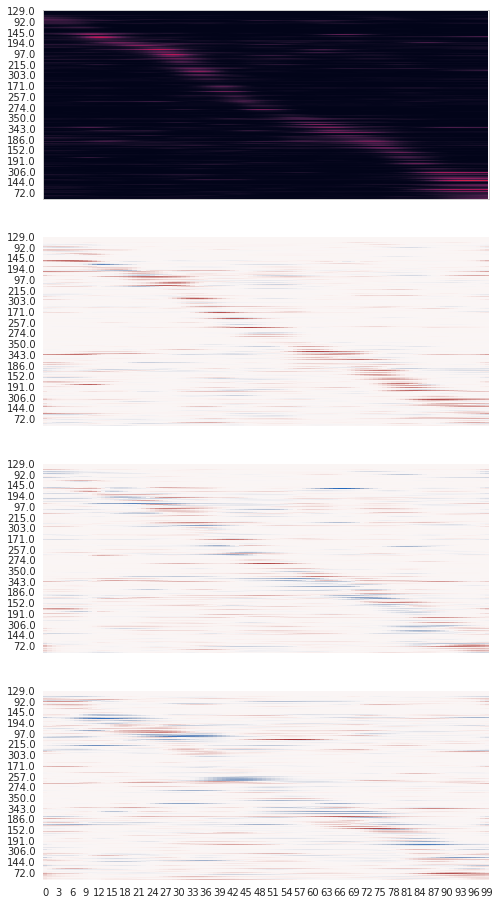

In [126]:
# visualize the PCs

import plot_ratemap_sequence as prs

%matplotlib inline
fig,axs = plt.subplots(4,1,sharex=True,sharey=True,figsize=(1*8,4*4))
fr_map_one= fr_map_trial_df_d.loc[task_ind,tt_ind].mean(axis=1).unstack()
fig,ax,order=prs.plot_population_sequence(fr_map_one,normalize=False,fig=fig,ax=axs[0])
for ii in range(w_l_allfac_fit_highlam.shape[-1]):
    w_one = w_l_allfac_fit_highlam[:,:,ii].T
    w_one_df=pd.DataFrame(w_one,index=fr_map_one.index)
    sns.heatmap(data=w_one_df.loc[order],cmap='vlag',center=0,ax=axs[ii+1],cbar=False)